# Face Mask Detection

### Objetivo:
*   Detectar y clasificar si las personas en las imágenes están con o sin mascarilla puesta

### Data:


*   All the images with the face mask (~6K) are scrapped from google search and all the images without the face mask are preprocessed from the CelebFace dataset created by Jessica Li (https://www.kaggle.com/jessicali9530).





In [ ]:
import numpy as np
import sympy as sp

import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import datasets, layers, models, losses
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, AveragePooling2D, MaxPooling2D, Flatten, Activation, Lambda, Dropout, BatchNormalization, Input, Flatten
from tensorflow.keras.losses import BinaryCrossentropy            
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [ ]:
#Para poder usar las librerias de opencv
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

     |████████████████████████████████| 25.0 MB 1.5 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 30.6 MB 1.4 MB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [ ]:
#carpeta de imagenes
!unzip Facemask1.zip

Archive:  Facemask1.zip
   creating: Face Mask Dataset 1/Test/
   creating: Face Mask Dataset 1/Test/WithMask/
  inflating: Face Mask Dataset 1/Test/WithMask/Augmented_530_370029.png  
  inflating: Face Mask Dataset 1/Test/WithMask/Augmented_530_6138724.png  
  inflating: Face Mask Dataset 1/Test/WithMask/Augmented_530_6846848.png  
  inflating: Face Mask Dataset 1/Test/WithMask/Augmented_532_6705344.png  
  inflating: Face Mask Dataset 1/Test/WithMask/Augmented_534_7216053.png  
  inflating: Face Mask Dataset 1/Test/WithMask/Augmented_535_101453.png  
  inflating: Face Mask Dataset 1/Test/WithMask/Augmented_536_7576091.png  
  inflating: Face Mask Dataset 1/Test/WithMask/Augmented_539_2126763.png  
  inflating: Face Mask Dataset 1/Test/WithMask/Augmented_540_2621888.png  
  inflating: Face Mask Dataset 1/Test/WithMask/Augmented_541_812397.png  
  inflating: Face Mask Dataset 1/Test/WithMask/Augmented_665_116492.png  
  inflating: Face Mask Dataset 1/Test/WithMask/Augmented_666_6106924

### Distribución (with/without mask):


*   Train: 1190/1030
*   Validation: 115/130
*   Test: 113/119

Preparación de las direcciones para cada archivo de imagen

In [ ]:
import sys
import cv2
import glob
import numpy as np
import pickle as cPickle
import time
import random
import scipy.cluster.vq as vq
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

def prepareFiles(rootpath):
	current_GT_id=0
	filenames=[]
	GT_ids=[]
	GT_labels=[]
	classpath = sorted(glob.glob(rootpath+'*'))
	for i in classpath:
		filespath = sorted(glob.glob(i+'/*.png'))
		for j in filespath:
			filenames.append(j)
			GT_ids.append(current_GT_id)
			GT_labels.append(i.split('/')[-1])
		current_GT_id+=1
	return(filenames,GT_ids,GT_labels)

In [ ]:
# Directorio raiz donde se encuentran todas las imágenes de aprendizaje
dataset_folder_train='./Face Mask Dataset 1/Train/'

# Directorio raiz donde se encuentran todas las imágenes de aprendizaje
dataset_folder_valid='./Face Mask Dataset 1/Validation/'

# Directorio raiz donde se encuentran todas las imágenes de test
dataset_folder_test='./Face Mask Dataset 1/Test/'

In [ ]:
# Separación de train, valid, test
filenames_train,GT_ids_train,GT_labels_train = prepareFiles(dataset_folder_train)
filenames_valid,GT_ids_valid,GT_labels_valid = prepareFiles(dataset_folder_valid)
filenames_test,GT_ids_test,GT_labels_test = prepareFiles(dataset_folder_test)


#filenames_train: contiene todas las imágenes de train
#GT_ids_train: contiene las clases a la que pertenecen cada imagen
#GT_labels_train: son las etiquetas de cada clase de imágen

Probar que se puede ver la dirección del archivo

In [ ]:
filenames_train[799]

'./Face Mask Dataset 1/Train/WithMask/Augmented_796_2651449.png'

In [ ]:
GT_ids_train[0]

0

In [ ]:
# funcion para extraer las imagenes en formato GRAY
def getKeypointsDescriptors(filenames):
  A=[]
  print('Obtaining the images matrix from the filenames')
  init=time.time()
  for filename in filenames:
    ima=cv2.imread(filename)
    ima = cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    dim = (256, 256)
    ima = cv2.resize(ima, dim, interpolation = cv2.INTER_AREA)
    A.append(ima)
  end=time.time()
  print('Done in '+str(end-init)+' secs.')
  return(A)

Obtención de las imágenes

In [ ]:
#Train:
X_train = getKeypointsDescriptors(filenames_train)
y_train = GT_ids_train 

#Validation:
X_valid = getKeypointsDescriptors(filenames_valid)
y_valid = GT_ids_valid 

#Test:
X_test = getKeypointsDescriptors(filenames_test)
y_test = GT_ids_test

Obtaining the images matrix from the filenames
Done in 2.588069200515747 secs.
Obtaining the images matrix from the filenames
Done in 0.3240017890930176 secs.
Obtaining the images matrix from the filenames
Done in 0.25390172004699707 secs.


Se convierte a formato de array

In [ ]:
X_train = np.array(X_train)
X_valid = np.array(X_valid)
X_test = np.array(X_test)

In [ ]:
y_train = np.array(y_train)
y_valid = np.array(y_valid)
y_test = np.array(y_test)

In [ ]:
import numpy as np
np.unique(y_train)

#Clasificador binario -> No es necesario one hot encoder

# aqui se busca codificar cada etiqueta de salida
# 0-> sin mascarilla y 1-> con mascarilla

array([0, 1])

In [ ]:
# Tamaños (With and Wuthout mask)
print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de validación:", X_valid.shape)
print("Tamaño del conjunto de prueba:", X_test.shape)

# Número de datos de entrenamiento y de prueba
ntrain = X_train.shape[0]
nvalid = X_valid.shape[0]
ntest = X_test.shape[0]

# Tamaño de la imagen
npx = X_train.shape[1] 

Tamaño del conjunto de entrenamiento: (2220, 256, 256)
Tamaño del conjunto de validación: (245, 256, 256)
Tamaño del conjunto de prueba: (232, 256, 256)


Mostrando 3 imágenes de ejemplos

In [ ]:
#Dado que los labels de la data están basados en números, genero este vector para poder facilitar visualmente
class_names = ['Wearing mask', 'No wearing mask']

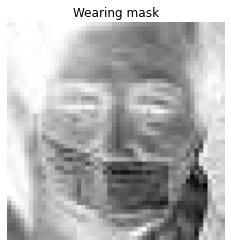

In [ ]:
#mostrar imagen
idx = 0
plt.imshow(X_train[idx], cmap='binary')
plt.title(class_names[y_train[idx]])
plt.axis('off')  #quitar ejes para que se vea mejor
plt.show()

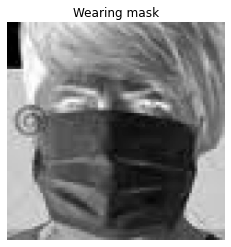

In [ ]:
#mostrar imagen
idx = 100
plt.imshow(X_train[idx], cmap='binary')
plt.title(class_names[y_train[idx]])
plt.axis('off')  #quitar ejes para que se vea mejor
plt.show()

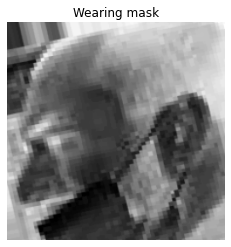

In [ ]:
#mostrar imagen
idx = 811
plt.imshow(X_train[idx], cmap='binary')
plt.title(class_names[y_train[idx]])
plt.axis('off')  #quitar ejes para que se vea mejor
plt.show()

Preprocesamiento:

In [ ]:
# Aumentar 1 dimension para que esté en formato que acepta Keras (escala a grises)
X_train = X_train.reshape(ntrain, npx, npx, 1) 
X_valid = X_valid.reshape(nvalid, npx, npx, 1)
X_test = X_test.reshape(ntest, npx, npx, 1)   

print("Tamaño modificado del conjunto de entrenamiento:", X_train.shape)
print("Tamaño modificado del conjunto de validacion:", X_valid.shape)
print("Tamaño modificado del conjunto de prueba:", X_test.shape)

Tamaño modificado del conjunto de entrenamiento: (2220, 256, 256, 1)
Tamaño modificado del conjunto de validacion: (245, 256, 256, 1)
Tamaño modificado del conjunto de prueba: (232, 256, 256, 1)


In [ ]:
X_train[0,0,0]

array([15], dtype=uint8)

In [ ]:
#Normalizando  (EJECUTAR 1 SOLA VEZ)
X_train = X_train/255.        #el . es para que sea float
X_valid = X_valid/255.
X_test = X_test/255.

In [ ]:
X_train[0,0,0]

array([0.05882353])

# Creando Red Neuronal (diseño simple)

In [ ]:
# OPCION BASICA 
model = Sequential()
model.add(Flatten(input_shape=(256,256,1))) #Flatten convierte la imagen en un vector -> 256x256=65536
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  

model.compile(loss=BinaryCrossentropy(),
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [ ]:
history = model.fit(
          x=X_train,
          y=y_train, # datos de entrenamiento
          batch_size=32, # dimension del paquete
          epochs=10, # epocas
          validation_data=(X_valid, y_valid), # validacion
          shuffle=True, # ordenamiento no aleatorio
          verbose=True
         )

#batch_size: define la cantidad de subgrupos a entrenar del grupo total
#si tengo 1000 datos, debo hacer un batch_size multiplo de aquel valor -> 10 o 100

Epoch 1/10
70/70 [==============================] - 15s 191ms/step - loss: 3.5468 - accuracy: 0.6162 - val_loss: 0.3746 - val_accuracy: 0.8531
Epoch 2/10
70/70 [==============================] - 14s 193ms/step - loss: 1.1505 - accuracy: 0.7365 - val_loss: 0.4100 - val_accuracy: 0.8694
Epoch 3/10
70/70 [==============================] - 10s 148ms/step - loss: 0.6306 - accuracy: 0.8059 - val_loss: 0.3879 - val_accuracy: 0.8898
Epoch 4/10
70/70 [==============================] - 7s 107ms/step - loss: 0.4584 - accuracy: 0.8428 - val_loss: 1.0631 - val_accuracy: 0.7020
Epoch 5/10
70/70 [==============================] - 8s 107ms/step - loss: 0.7246 - accuracy: 0.7887 - val_loss: 0.5655 - val_accuracy: 0.8122
Epoch 6/10
70/70 [==============================] - 7s 107ms/step - loss: 0.5323 - accuracy: 0.8189 - val_loss: 0.8722 - val_accuracy: 0.7347
Epoch 7/10
70/70 [==============================] - 7s 106ms/step - loss: 0.3476 - accuracy: 0.8667 - val_loss: 0.5668 - val_accuracy: 0.7837
Epo

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

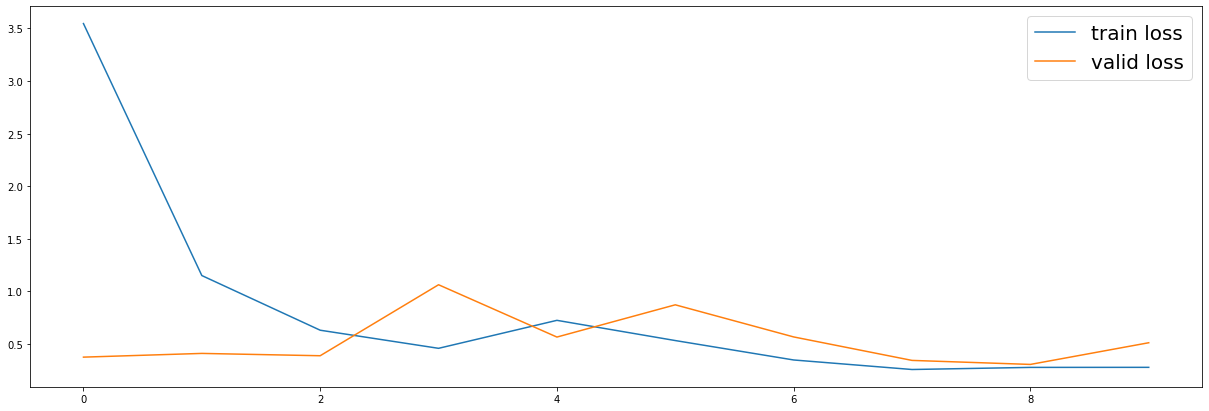

In [ ]:
plt.figure(figsize=(21,7))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='valid loss')
plt.legend(fontsize=20)

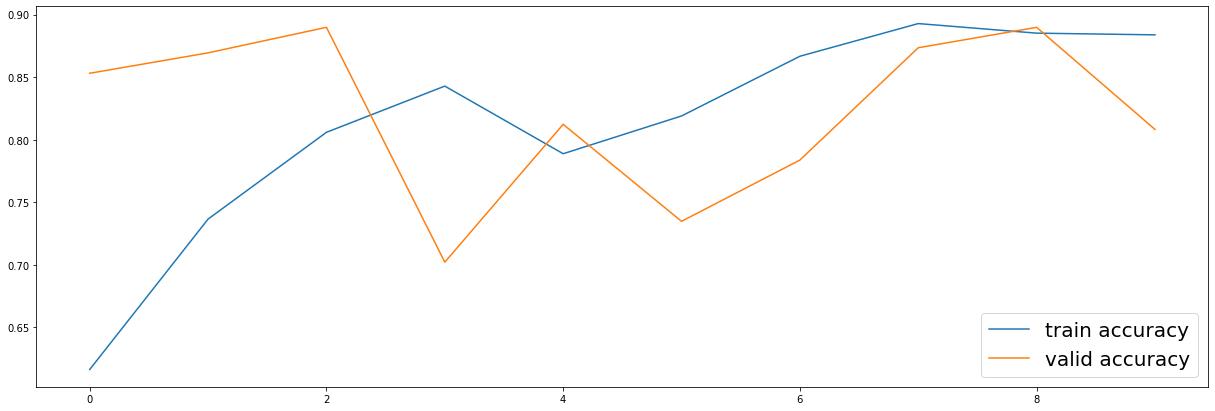

In [ ]:
plt.figure(figsize=(21,7))
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='valid accuracy')
plt.legend(fontsize=20)

# Creando Red Neuronal (diseño más complejo)

In [ ]:
model = Sequential()
model.add(Flatten(input_shape=(256,256,1)))     # entran 256x256x1 datos a cada neurona

# ¿Por qué un batch normalization? es útil para estandarizar las entradas de la red neuronal
# y así acelerar el proceso de entrenamiento proporcionando una mejor regularizacion y mejorar el accuracy

# capa 1
model.add(Dense(256))
model.add(BatchNormalization())           #el Batch debe estar entre la convalidación(Dense) y el activation
model.add(Activation('swish'))              #swish mejor que relu
model.add(Dropout(0.5))                       #borra aleatoriamente la mitad de las neuronas de esta capa con cada iteración
                                              #dropout sirve para evitar la memorización de datos(overfitting) 
# capa 2                                          
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('swish'))         
model.add(Dropout(0.5))

# capa 3
model.add(Dense(64))
model.add(BatchNormalization())
model.add(Activation('swish'))
model.add(Dropout(0.5))

# capa de salida
model.add(Dense(1))
model.add(Activation('sigmoid')) # clasificacion binaria

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 65536)             0         
                                                                 
 dense_3 (Dense)             (None, 256)               16777472  
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                      

In [ ]:
model.compile(loss=BinaryCrossentropy(), # costo
             optimizer=Adam(learning_rate=0.001), # optimizador
             metrics=['accuracy', 'AUC']) # metricas

In [ ]:
filepath = './my_best_model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'       #para almacenar cada mejor modelo encontrado con cada iteracion

cp = ModelCheckpoint(filepath=filepath, 
                     monitor='val_loss',
                     verbose=1, 
                     save_best_only=True,
                     mode='min')
#el checkpoint(cp) guardará los parámetros del modelo que generen el mínimo de 'val_loss' y se quedará con esos hasta que aparezca un menor a loss

es = EarlyStopping(monitor='val_loss',
                   patience=20,
                   mode='min',
                   verbose=0,
                   restore_best_weights=True)
# si "es" detecta 20 veces seguidas que el 'val_loss' está subiendo (mal resultado) entonces parará las iteraciones

pl = ReduceLROnPlateau(monitor='val_loss',
                       factor=0.2,
                       patince=5,
                       verbose=0,
                       mode='min')
#reduce(multiplica) al 'learning_rate' en un factor de 0.2 cada 5 veces seguidas que el val_loss se reduzca

In [ ]:
history = model.fit(
          x=X_train,
          y=y_train, # datos de entrenamiento
          batch_size=32, # dimension del paquete
          epochs=10, # epocas
          validation_data=(X_valid, y_valid), # validacion
          shuffle=True, # ordenamiento no aleatorio
          verbose=True,
          callbacks=[cp, es, pl]
         )

#batch_size: define la cantidad de subgrupos a entrenar del grupo total
#si tengo 1000 datos, debo hacer un batch_size multiplo de aquel valor -> 10 o 100

Epoch 1/10
70/70 [==============================] - ETA: 0s - loss: 0.5972 - accuracy: 0.6950 - auc: 0.7577
Epoch 00001: val_loss improved from inf to 1.69485, saving model to ./my_best_model.epoch01-loss1.69.hdf5
70/70 [==============================] - 10s 116ms/step - loss: 0.5972 - accuracy: 0.6950 - auc: 0.7577 - val_loss: 1.6948 - val_accuracy: 0.5184 - val_auc: 0.7631 - lr: 0.0010
Epoch 2/10
70/70 [==============================] - ETA: 0s - loss: 0.4263 - accuracy: 0.8113 - auc: 0.8860
Epoch 00002: val_loss improved from 1.69485 to 1.16779, saving model to ./my_best_model.epoch02-loss1.17.hdf5
70/70 [==============================] - 8s 110ms/step - loss: 0.4263 - accuracy: 0.8113 - auc: 0.8860 - val_loss: 1.1678 - val_accuracy: 0.5714 - val_auc: 0.9206 - lr: 0.0010
Epoch 3/10
70/70 [==============================] - ETA: 0s - loss: 0.3511 - accuracy: 0.8450 - auc: 0.9247
Epoch 00003: val_loss improved from 1.16779 to 0.28471, saving model to ./my_best_model.epoch03-loss0.28.hd

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'auc', 'val_loss', 'val_accuracy', 'val_auc', 'lr'])

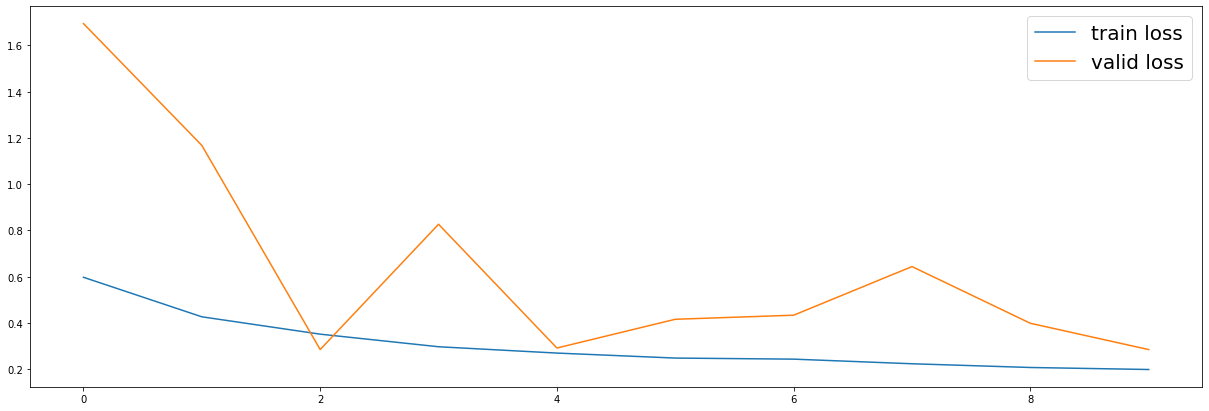

In [ ]:
plt.figure(figsize=(21,7))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='valid loss')
plt.legend(fontsize=20)

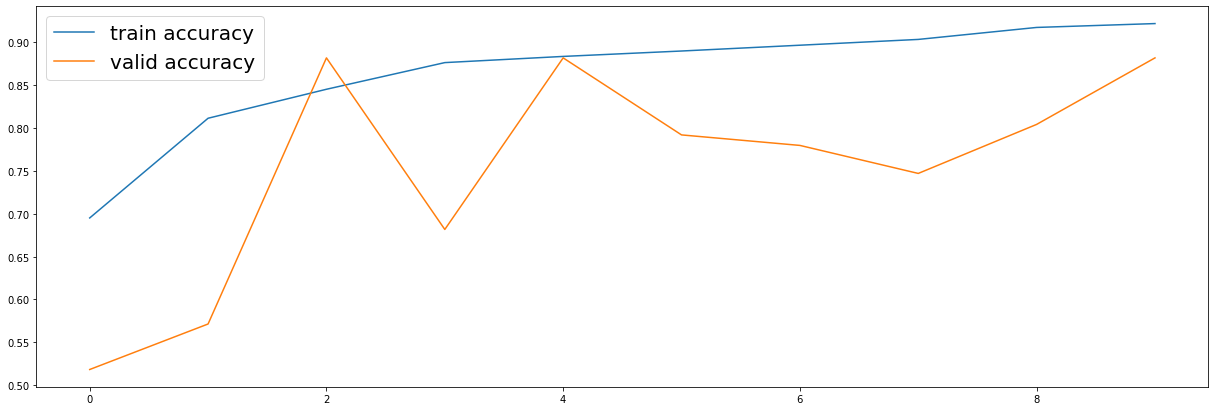

In [ ]:
plt.figure(figsize=(21,7))
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='valid accuracy')
plt.legend(fontsize=20)

# Creando Red Neuronal (arquitectura AlexNet)

In [ ]:
model = models.Sequential()

model.add(layers.experimental.preprocessing.Resizing(256, 256, input_shape=X_train.shape[1:]))

model.add(layers.Conv2D(96, 11, strides=4, padding='same')) # tamano = 64x64x96
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((3,3), strides=2)) # tamano = 31x31x96

model.add(layers.Conv2D(256, 5, strides=4, padding='same')) # tamano = 8x8x256
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((3,3), strides=2)) # tamano = 3x3x256

model.add(layers.Conv2D(384, 3, strides=4, padding='same')) # tamano = 1x1x384
model.add(layers.Activation('relu'))

model.add(layers.Conv2D(256, 3, strides=4, padding='same')) # tamano = 1x1x256
model.add(layers.Activation('relu'))

model.add(layers.Flatten())

# capa 1
model.add(Dense(256))
model.add(BatchNormalization())           #el Batch debe estar entre la convalidación(Dense) y el activation
model.add(Activation('swish'))              #swish mejor que relu
model.add(Dropout(0.5))                       #borra aleatoriamente la mitad de las neuronas de esta capa con cada iteración
                                              #dropout sirve para evitar la memorización de datos(overfitting) 
# capa 2                                          
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('swish'))         
model.add(Dropout(0.5))

# capa 3
model.add(Dense(64))
model.add(BatchNormalization())
model.add(Activation('swish'))
model.add(Dropout(0.5))

model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 256, 256, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 96)        11712     
                                                                 
 activation_4 (Activation)   (None, 64, 64, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 256)         614656    
                                                                 
 activation_5 (Activation)   (None, 8, 8, 256)         0         
                                                      

In [ ]:
model.compile(loss=BinaryCrossentropy(), # costo
             optimizer=Adam(learning_rate=0.001), # optimizador
             metrics=['accuracy', 'AUC']) # metricas

In [ ]:
filepath = './my_best_model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'       #para almacenar cada mejor modelo encontrado con cada iteracion

cp = ModelCheckpoint(filepath=filepath, 
                     monitor='val_loss',
                     verbose=1, 
                     save_best_only=True,
                     mode='min')
#el checkpoint(cp) guardará los parámetros del modelo que generen el mínimo de 'val_loss' y se quedará con esos hasta que aparezca un menor a loss

es = EarlyStopping(monitor='val_loss',
                   patience=5,
                   mode='min',
                   verbose=0,
                   restore_best_weights=True)
# si "es" detecta 20 veces seguidas que el 'val_loss' está subiendo (mal resultado) entonces parará las iteraciones

pl = ReduceLROnPlateau(monitor='val_loss',
                       factor=0.2,
                       patince=5,
                       verbose=0,
                       mode='min')
#reduce(multiplica) al 'learning_rate' en un factor de 0.2 cada 5 veces seguidas que el val_loss se reduzca

In [ ]:
history = model.fit(
          x=X_train,
          y=y_train, # datos de entrenamiento
          batch_size=32, # dimension del paquete
          epochs=10, # epocas
          validation_data=(X_valid, y_valid), # validacion
          shuffle=True, # ordenamiento no aleatorio
          verbose=True,
          callbacks=[cp, es, pl]
         )

#batch_size: define la cantidad de subgrupos a entrenar del grupo total
#si tengo 1000 datos, debo hacer un batch_size multiplo de aquel valor -> 10 o 100

Epoch 1/10
70/70 [==============================] - ETA: 0s - loss: 0.6929 - accuracy: 0.6279 - auc: 0.6663
Epoch 00001: val_loss improved from inf to 3.21156, saving model to ./my_best_model.epoch01-loss3.21.hdf5
70/70 [==============================] - 49s 670ms/step - loss: 0.6929 - accuracy: 0.6279 - auc: 0.6663 - val_loss: 3.2116 - val_accuracy: 0.4694 - val_auc: 0.5330 - lr: 0.0010
Epoch 2/10
70/70 [==============================] - ETA: 0s - loss: 0.4434 - accuracy: 0.7995 - auc: 0.8784
Epoch 00002: val_loss improved from 3.21156 to 0.85085, saving model to ./my_best_model.epoch02-loss0.85.hdf5
70/70 [==============================] - 47s 673ms/step - loss: 0.4434 - accuracy: 0.7995 - auc: 0.8784 - val_loss: 0.8509 - val_accuracy: 0.4653 - val_auc: 0.9208 - lr: 0.0010
Epoch 3/10
70/70 [==============================] - ETA: 0s - loss: 0.2754 - accuracy: 0.8982 - auc: 0.9552
Epoch 00003: val_loss improved from 0.85085 to 0.28478, saving model to ./my_best_model.epoch03-loss0.28.h

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'auc', 'val_loss', 'val_accuracy', 'val_auc', 'lr'])

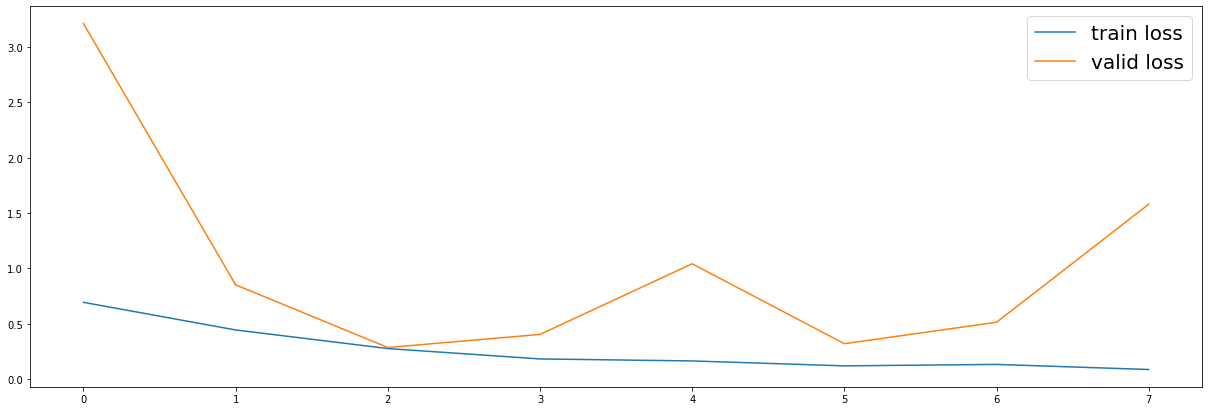

In [ ]:
plt.figure(figsize=(21,7))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='valid loss')
plt.legend(fontsize=20)

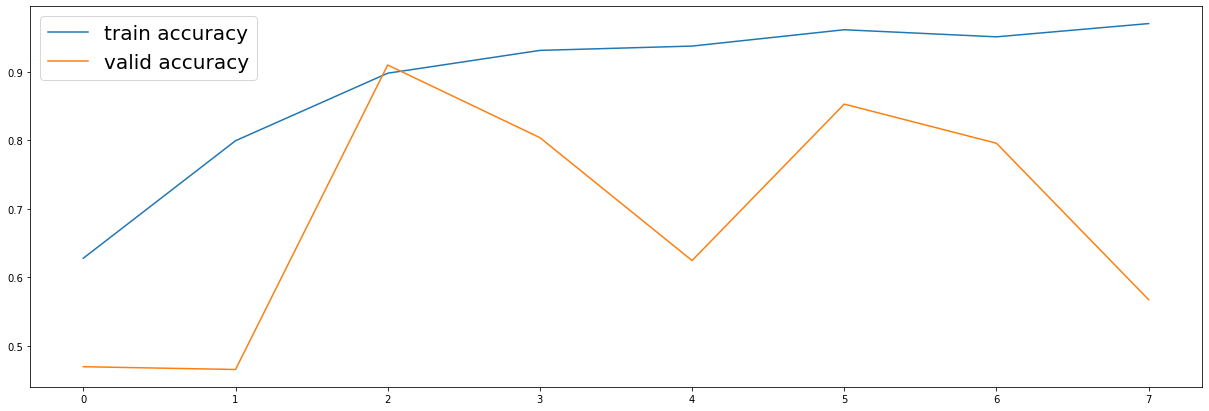

In [ ]:
plt.figure(figsize=(21,7))
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='valid accuracy')
plt.legend(fontsize=20)

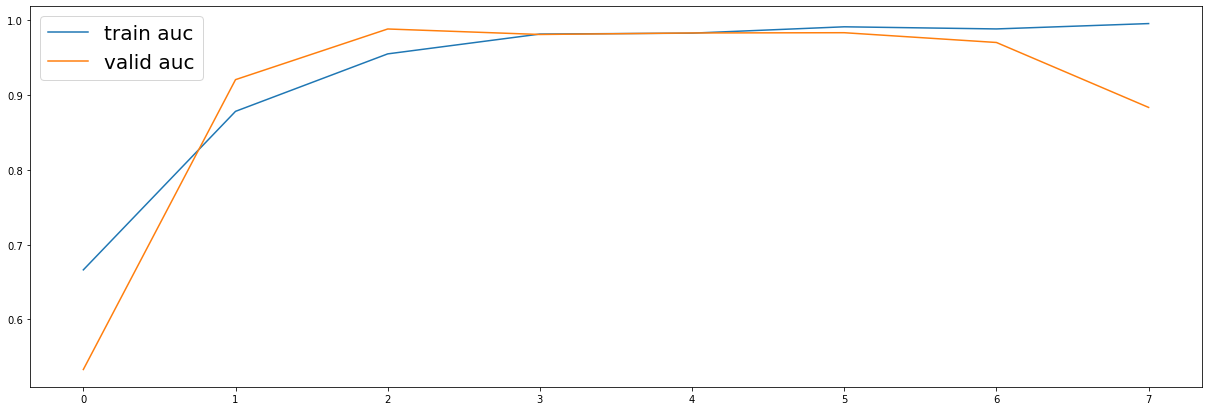

In [ ]:
plt.figure(figsize=(21,7))
plt.plot(history.history['auc'], label='train auc')
plt.plot(history.history['val_auc'], label='valid auc')
plt.legend(fontsize=20)

Rendimiento de los datos de prueba

In [ ]:
preds = model.evaluate(X_test, y_test)
print("loss =" + str(preds[0]))
print("Test accuracy =" + str(preds[1]))

8/8 [==============================] - 1s 127ms/step - loss: 0.3029 - accuracy: 0.8879 - auc: 0.9707
loss =0.3029332756996155
Test accuracy =0.8879310488700867


Matriz de confusión

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix

def make_confusion_matrix(y_true, y_pred, classes=None, figsize = (5, 5), text_size=15):
  # create the confusion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
  n_classes = cm.shape[0]

  # Let's prettify it
  fig, ax = plt.subplots(figsize=figsize)

  cax = ax.matshow(cm, cmap=plt.cm.Blues)
  fig.colorbar(cax)


  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title='Confusion Matrix',
        xlabel='Predicted Label',
        ylabel='True Label',
        xticks=np.arange(n_classes),
        yticks=np.arange(n_classes),
        xticklabels=labels,
        yticklabels=labels)
  # Set x-axis  labels to bottom
  ax.xaxis.set_label_position('bottom')
  ax.xaxis.tick_bottom()

  # Adjust label size
  ax.yaxis.label.set_size(text_size)
  ax.xaxis.label.set_size(text_size)
  ax.title.set_size(text_size)

  # Set threshold for different colors
  threshold = (cm.max() + cm.min())/2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)", 
            horizontalalignment='center',
            color='white' if cm[i, j] > threshold else 'black',
            size=text_size)

In [ ]:
class_names # etiquetas

['Wearing mask', 'No wearing mask']

In [ ]:
y_probs = model.predict(X_test) # calculando la probabilidad

In [ ]:
# reemplazamos las probabilidad para cada uno
y_preds = []

for i in range(len(y_probs)):
  y_pred = int(np.round(y_probs[i],0))  
  y_preds.append(y_pred)

# y_preds = np.argmax(y_probs, axis=1)
# y_preds

In [ ]:
confusion_matrix(y_true=y_test, y_pred=y_preds)

array([[ 91,  22],
       [  4, 115]])

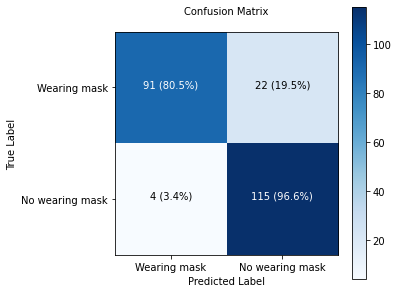

In [ ]:
make_confusion_matrix(y_true=y_test,
                      y_pred=y_preds,
                      classes=class_names,
                      figsize = (5, 5),
                      text_size=10)